## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
29045,00007569_009.png,No Finding,9,7569,49,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00007569_009.png
25877,00006807_000.png,No Finding,0,6807,62,F,PA,2048,2500,0.171,0.171,NaN,/data/images_004/images/00006807_000.png
7924,00002072_004.png,Atelectasis|Effusion|Infiltration,4,2072,9,M,AP,2048,2500,0.171,0.171,NaN,/data/images_002/images/00002072_004.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
label=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

for x in label:
    if len(x)>1:
        all_xray_df[x] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if x in finding else 0)

        
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
print(all_xray_df[all_xray_df['pneumonia_class']== 'Positive'])

             Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patien

## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(vargs, test_size=0.2, stratify=vargs['Pneumonia'], random_state=0)
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

In [7]:
 p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
 n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
 n_sample = sample(n_ind,len(p_ind))
 train_data=train_data.loc[p_ind+n_sample]
 vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
 vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
 vn_sample = sample(vn_ind,4*len(vp_ind))
 val_data=val_data.loc[vp_ind+vn_sample]

In [8]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1145
False    1145
Name: pneumonia_class, dtype: int64

In [9]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

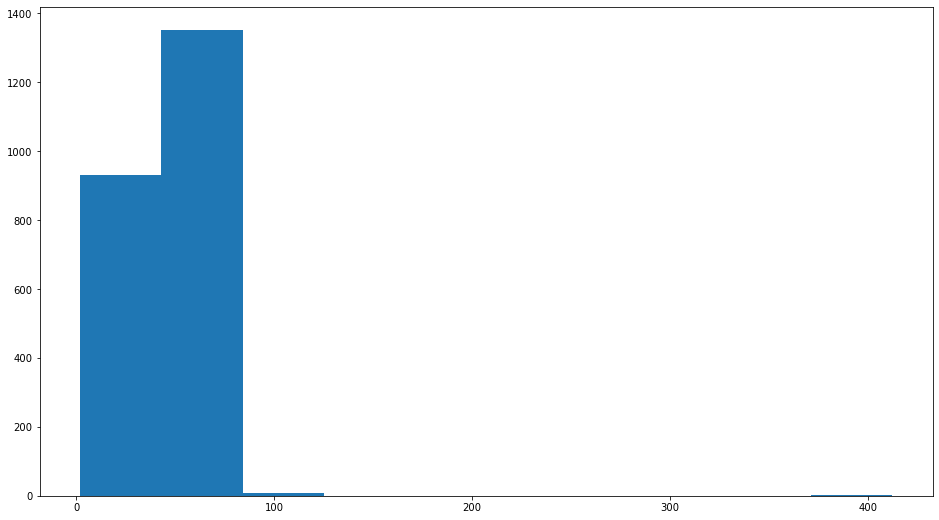

45.751528384279474


In [10]:
plt.figure(figsize=(16,9))
plt.hist(train_data['Patient Age'], 10)
plt.show()
print(train_data['Patient Age'].mean())
      

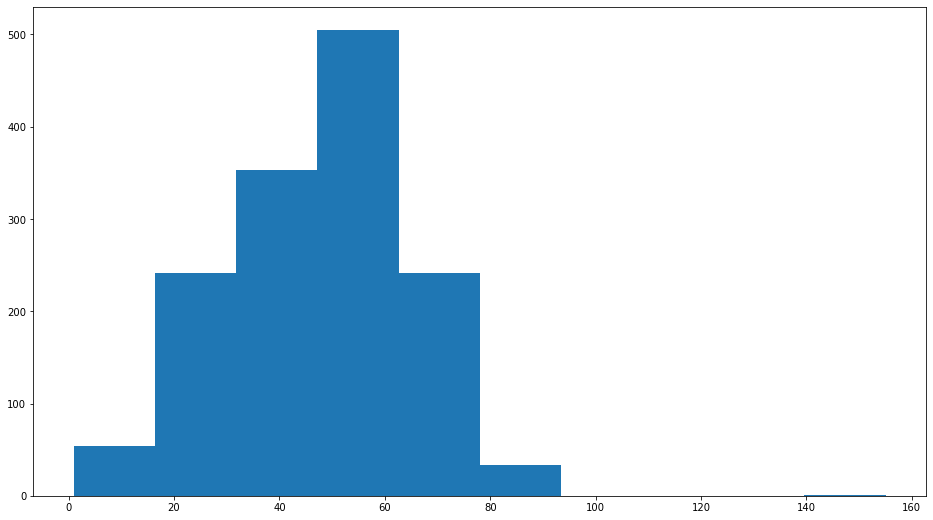

In [11]:
plt.figure(figsize=(16,9))
plt.hist(val_data['Patient Age'], 10)
plt.show()

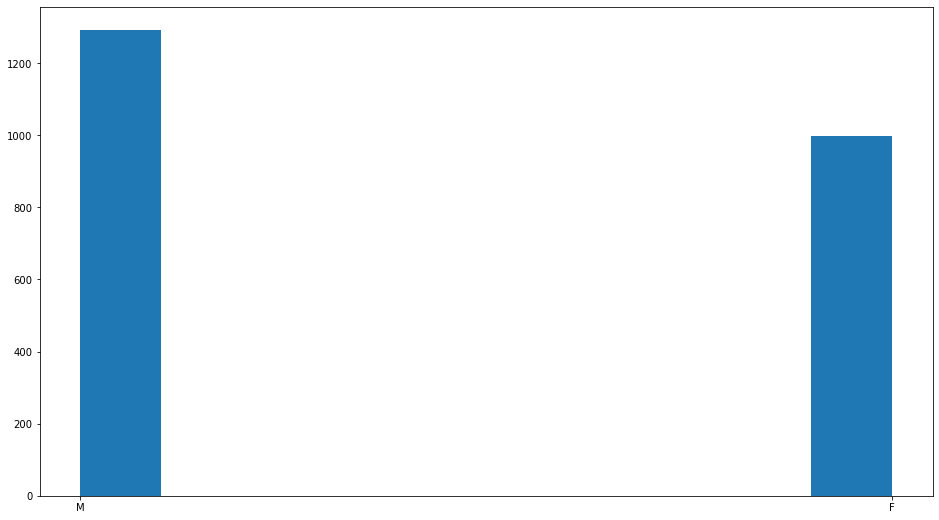

In [12]:
plt.figure(figsize=(16,9))
plt.hist(train_data['Patient Gender'])
plt.show()

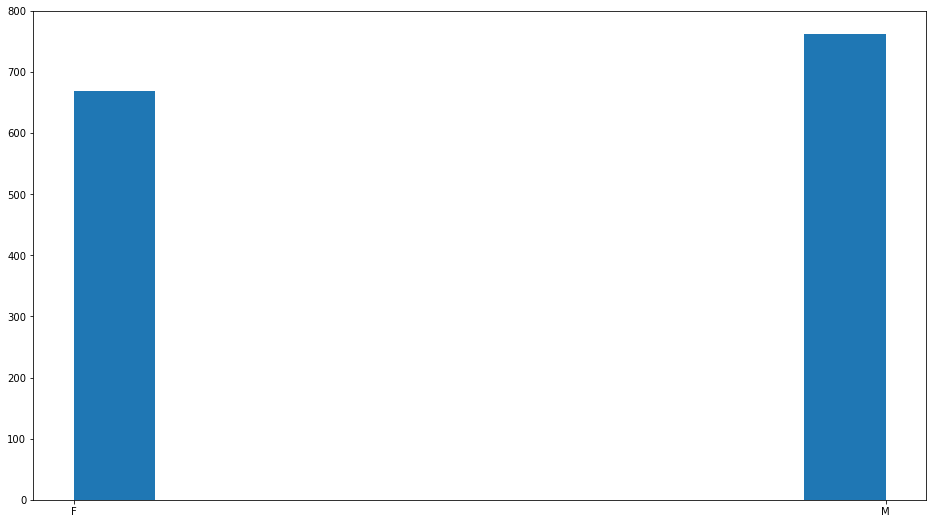

In [13]:
plt.figure(figsize=(16,9))
plt.hist(val_data['Patient Gender'])
plt.show()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      vertical_flip = False, 
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 25,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    
    return my_train_idg




def make_train_gen(my_train_idg,vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return train_gen


def make_val_gen(my_val_idg,vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 

    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=vargs, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = (224,224), 
                                 batch_size = 100 )
    
    # Todo
    return val_gen



def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg



In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
#valX, valY = val_gen.next()
#val_gen = make_val_gen(val_data)

#valX, valY = val_gen.next()
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [16]:
#my_train_idg = my_image_augmentation(train_data)
#train_gen = make_train_gen(my_train_idg, train_data)
train_idg = my_image_augmentation()
train_gen = make_train_gen(train_idg, train_data)

Found 2290 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.
Batch Mean: 1.2569687e-08 Batch Std: 0.9999958


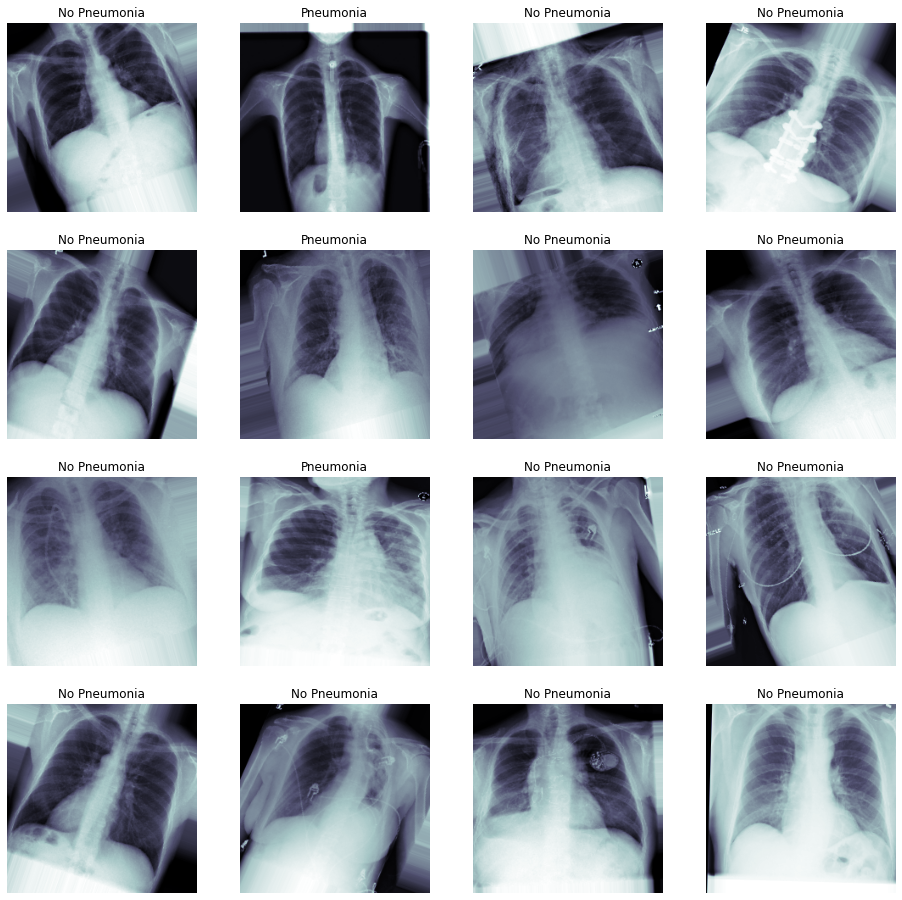

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_idg = my_image_augmentation()
train_gen = make_train_gen(train_idg, train_data)

t_x, t_y = next(train_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model(vargs):
    
     model = VGG16(include_top=True, weights='imagenet')
     transfer_layer = model.get_layer(vargs)
     vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
     
     print("VGG16 arch:")
     print(vgg_model.summary())
    
    
    # Todo
    
     return vgg_model


In [19]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    '''for layer in vgg_model.layers[0:freeze_layers]:
      layer.trainable = False'''
    
    ##
    
    new_model = Sequential()

    new_model.add(vgg_model)
    new_model.add(Flatten())
    #new_model.add(Dropout(0.3))
    #new_model.add(Dense(2048, activation = 'relu'))
    #new_model.add(Dropout(0.3))
    new_model.add(Dense(1024, activation = 'relu'))
    new_model.add(Dropout(0.3))
    new_model.add(Dense(512, activation = 'relu'))
    new_model.add(Dropout(0.3))
    new_model.add(Dense(256, activation = 'relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    '''
    new_model = Sequential()
    new_model.add(vgg_model)
    new_model.add(Flatten())
    new_model.add(Dense(2048, activation = 'relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(1024, activation = 'relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(512, activation = 'relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation = 'relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(1, activation = 'sigmoid'))'''
    
    
    optimizer = Adam(learning_rate = 1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
        
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]
weight_path="out/{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]


### Start training! 

In [21]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
vgg_model =  load_pretrained_model('block5_pool')
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)


553467904/553467096 [==============================] - 3s 0us/step
VGG16 arch:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 4s 44ms/sample


In [23]:
def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('out/Model_Training_Performance')
    plt.show()

    return

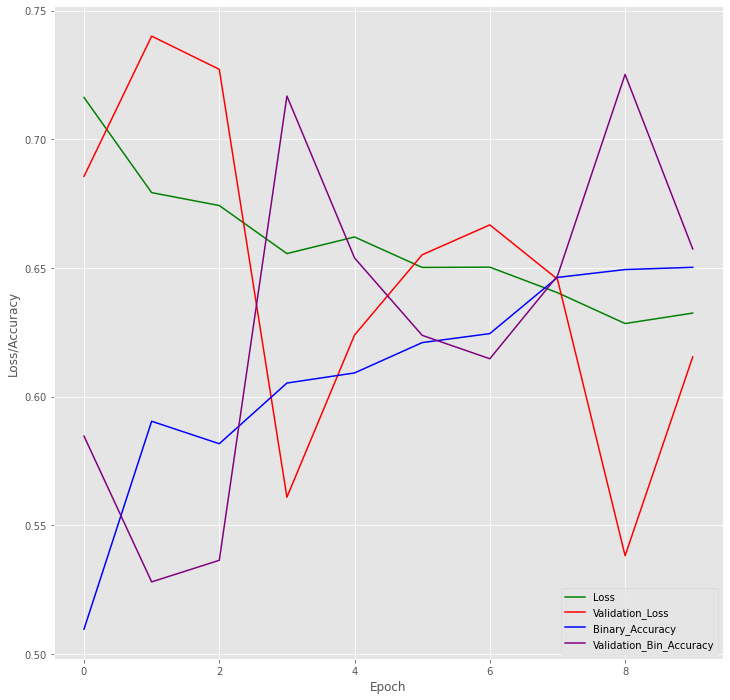

In [24]:
plot_history(history,10)

In [25]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return thresholds

def plot_pr_curve(t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    # plot the precision-recall curves
    baseline = sum(t_y==1) / len(t_y)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.plot(recall, precision, marker='.', label='Algorithm')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return 

    fig = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500
    )
    
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0
    )
    
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')

    fig.show()
    
    
    return

## what other performance statistics do you want to include here besides AUC? 

    

def get_statistics(t_y, p_y, threshold):
    
    tn, fp, fn, tp = confusion_matrix(t_y, p_y).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1_score = (2 * precision * recall) / (precision + recall)
    
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    
    return [threshold, sensitivity, specificity, precision, recall, f1_score, accuracy]
    



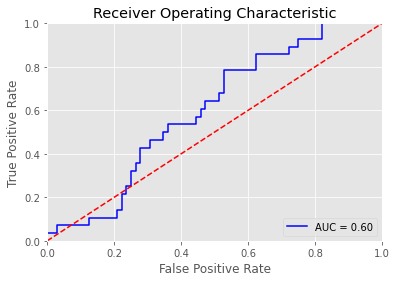

In [26]:
## plot figures
thresholds = plot_auc(valY, pred_Y)

# Todo

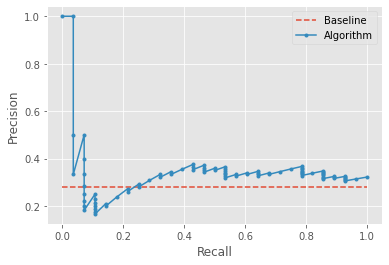

In [27]:
plot_pr_curve(valY, pred_Y)

In [28]:
statistics = []

for threshold in np.arange(0.0, 1.0, 0.1):
    pred_Y = (pred_Y >= threshold)
    statistics.append(get_statistics(valY, pred_Y, threshold))

df = pd.DataFrame(statistics,
                     columns=['Threshold', 'Sensitivity', 'Spec.', 'Precision', 'Recall', 'F1_score', 'Accuracy'])

df

,Threshold,Sensitivity,Spec.,Precision,Recall,F1_score,Accuracy
0,0.0,1.0,0.0,0.28,1.0,0.4375,0.28
1,0.1,1.0,0.0,0.28,1.0,0.4375,0.28
2,0.2,1.0,0.0,0.28,1.0,0.4375,0.28
3,0.3,1.0,0.0,0.28,1.0,0.4375,0.28
4,0.4,1.0,0.0,0.28,1.0,0.4375,0.28
5,0.5,1.0,0.0,0.28,1.0,0.4375,0.28
6,0.6,1.0,0.0,0.28,1.0,0.4375,0.28
7,0.7,1.0,0.0,0.28,1.0,0.4375,0.28
8,0.8,1.0,0.0,0.28,1.0,0.4375,0.28
9,0.9,1.0,0.0,0.28,1.0,0.4375,0.28


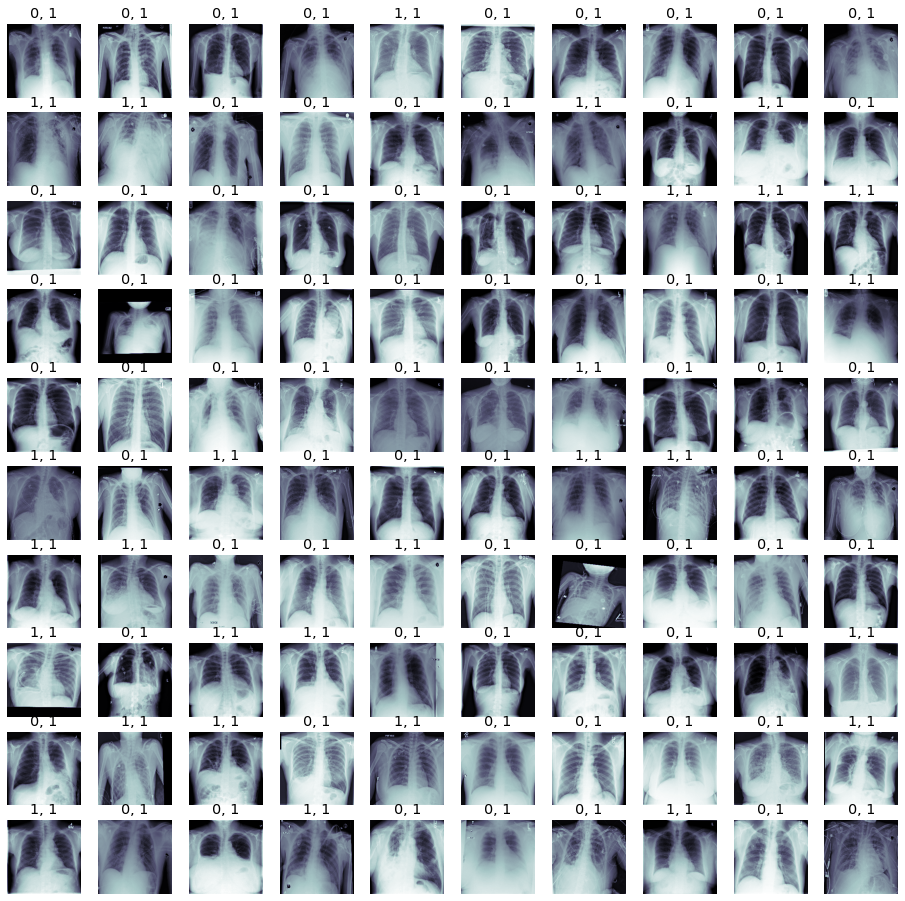

In [29]:
chosen_threshold = 0.6
pred_Y = (pred_Y >= threshold)
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):#this was testY instead of valY, I changed.
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > chosen_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > chosen_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [30]:
'''vgg_model = load_pretrained_model('block5_pool')
my_model2 = build_my_model2nd(vgg_model)
historytwo = my_model2.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)'''

"vgg_model = load_pretrained_model('block5_pool')\nmy_model2 = build_my_model2nd(vgg_model)\nhistorytwo = my_model2.fit_generator(train_gen, \n                           validation_data = val_gen, \n                           epochs = 10,\n                           callbacks = callbacks_list)"

In [31]:
#plot_history(historytwo,10)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [32]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [33]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

NameError: name 'new_model' is not defined